In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skactiveml.utils import MISSING_LABEL
from skactiveml.pool import RandomSampling, TypiClust, GreedySamplingX, CoreSet, ProbCover, DiscriminativeAL, SubSamplingWrapper, ParallelUtilityEstimationWrapper, UncertaintySampling
from sklearn.datasets import make_multilabel_classification

import numpy as np

In [30]:
import warnings
#mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

In [3]:
X, y_true = make_multilabel_classification(n_samples=200,
                                           n_features=20,
                                           n_classes=5,
                                           n_labels=2,
                                           random_state=0,)

In [4]:
from sklearn.multioutput import MultiOutputClassifier
from skactiveml.classifier import SklearnClassifier, SklearnMultilabelClassifier
from sklearn.linear_model import LogisticRegression

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from copy import deepcopy

X, y_true = make_multilabel_classification(n_samples=5000,
                                      n_features=20,
                                      n_classes=5,
                                      n_labels=2,
                                      random_state=0)

X_train, X_test, y_train_true, y_test = train_test_split(
    X, y_true, test_size=0.2, random_state=0
)

In [153]:
y_train_true.sum(axis=0)

array([1472, 1724, 1609, 1469, 1262])

In [146]:
clf = SklearnMultilabelClassifier(MultiOutputClassifier(LogisticRegression()), classes=np.arange(y_train_true.shape[-1]))
qs = UncertaintySampling(ml_agg=np.max)
#qs = RandomSampling()
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
#clf.fit(X,y)

for c in range(5):
    print(c)
    query_idx = qs.query(X=X, y=y, batch_size=5, clf=clf)
    print(query_idx)
    y[query_idx] = y_true[query_idx]
    clf.fit(X, y)

0
[4288 3179 4308  480 3934]
1
[3543 2147 3815 4218 3643]
2
[1356 3485 1205 2041 3702]
3
[1391 2837 3436  945   65]
4
[4181 4820 4379 2973 1618]


In [147]:
clf = MultiOutputClassifier(LogisticRegression())
clf.fit(X_train, y_train_true)
y_pred = clf.predict(X_test)
best_acc = accuracy_score(y_test, y_pred)

RandomSampling
UncertaintySampling_max
UncertaintySampling_sum


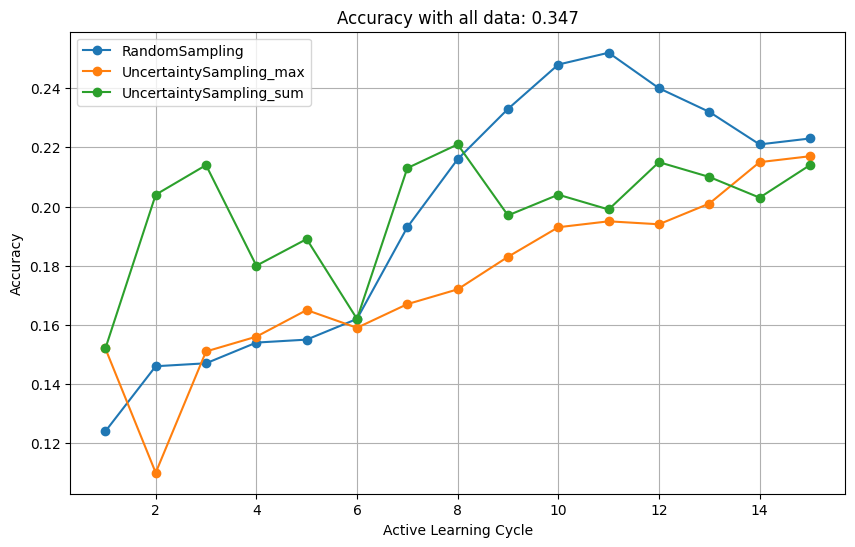

In [163]:
n_cycles = 15
batch_size = 5
strategies = {
    'RandomSampling': RandomSampling(random_state=0),
    # 'TypiClust': TypiClust(),
    # "GSx": GreedySamplingX(),
    #"CoreSet": CoreSet(random_state=8),
    # "ProbCover": ProbCover(),
    # "DAL": DiscriminativeAL(),
    "UncertaintySampling_max": UncertaintySampling(ml_agg=np.max, random_state=0),
    "UncertaintySampling_sum": UncertaintySampling(ml_agg=np.sum, random_state=0),
}

strategy_accuracies = {name: [] for name in strategies.keys()}
y_train = np.full(shape=y_train_true.shape, fill_value=MISSING_LABEL)
clf1 = SklearnClassifier(LogisticRegression(), classes=2)

for name, qs in strategies.items():
    print(name)
    y_train = np.full(shape=y_train_true.shape, fill_value=MISSING_LABEL)
    clf = SklearnMultilabelClassifier(MultiOutputClassifier(LogisticRegression()), classes=np.arange(y_train_true.shape[-1]), random_state=0)

    clf.fit(X_train, y_train)

    accuracies = []
    for c in range(n_cycles):
        #print(name, c)
        if name == "DAL":
            query_idx = qs.query(X=X_train, y=y_train, discriminator=clf1, batch_size=batch_size)
        elif name.startswith("Uncertainty"):
            query_idx = qs.query(X=X_train, y=y_train, clf=clf, batch_size=batch_size, fit_clf=False)
        else:
            query_idx = qs.query(X=X_train, y=y_train, batch_size=batch_size)
        y_train[query_idx] = y_train_true[query_idx]

        probas = clf.predict_proba(X_train)
        # print(np.max(-np.abs(0.5 - probas), axis=1)[query_idx])
        # print(np.max(-np.abs(0.5 - probas), axis=1))
        # print("idx", query_idx)
        # print("probas", [round(i, 5) for i in probas[query_idx][0]])
        # print("labels", y_train_true[query_idx][0])
        # print("-"*10)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    strategy_accuracies[name] = accuracies

plt.figure(figsize=(10, 6))
for name, accuracies in strategy_accuracies.items():
    plt.plot(range(1, n_cycles + 1), accuracies, marker='o', label=name)

plt.title(f"Accuracy with all data: {best_acc}")
plt.xlabel('Active Learning Cycle')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()